In [1]:
! pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 343.4 kB/s eta 0:00:00a 0:00:01
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 1.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 1.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 1.8 MB/s eta 0:00:0000:0100:01
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)


In [3]:
import pandas as pd
import numpy as np
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = '../datasets/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

print(X_train,y_train)
print(np.array(X_train).shape)

[[[-1.190e-01 -5.500e-02  6.400e-02 ... -2.600e-02 -3.900e-02 -7.900e-02]
  [-1.160e-01 -5.100e-02  6.500e-02 ... -3.100e-02 -3.400e-02 -7.400e-02]
  [-1.200e-01 -4.400e-02  7.600e-02 ... -2.800e-02 -2.900e-02 -6.900e-02]
  ...
  [ 6.900e-02  0.000e+00 -6.900e-02 ...  2.400e-02 -4.100e-02 -5.800e-02]
  [ 8.600e-02  4.000e-03 -8.100e-02 ...  2.420e-01 -4.600e-02 -9.800e-02]
  [ 2.200e-02 -3.100e-02 -5.400e-02 ...  1.430e-01 -3.500e-02 -1.200e-01]]

 [[ 4.000e-03  1.380e-01  1.340e-01 ...  1.920e-01  8.300e-02  8.800e-02]
  [-2.000e-02  1.160e-01  1.360e-01 ...  1.560e-01  5.700e-02  6.300e-02]
  [-5.300e-02  9.200e-02  1.450e-01 ...  1.070e-01  1.300e-02  2.200e-02]
  ...
  [ 1.210e-01  3.980e-01  2.770e-01 ... -1.065e+00 -4.920e-01 -1.560e-01]
  [-3.260e-01  5.700e-02  3.830e-01 ... -2.800e-01 -1.750e-01 -7.100e-02]
  [-3.480e-01 -5.600e-02  2.920e-01 ... -3.080e-01 -2.310e-01 -1.450e-01]]

 [[-2.900e-02 -7.900e-02 -4.900e-02 ... -1.030e-01 -7.600e-02 -6.600e-02]
  [-3.500e-02 -7.000e-

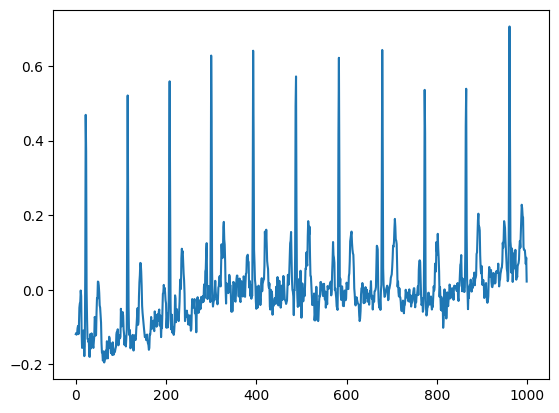

In [4]:
import matplotlib.pyplot as plt
# plot the first 2 signals
plt.plot(X_train[0, :, 0])
plt.show()

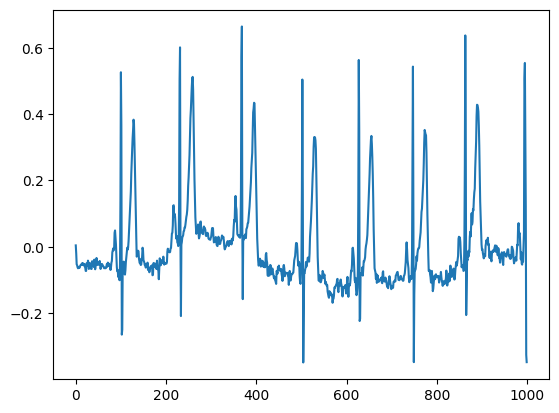

In [5]:
plt.plot(X_train[1, :, 0])
plt.show()

In [6]:
# putting the first lead ecg data into a variable called 1st_lead_ecg_train
first_lead_ecg_train = X_train[:, :, 0]
print(first_lead_ecg_train.shape)

(19601, 1000)


In [7]:
# putting the remaining lead ecg data into a variable called remaining_lead_ecg_train
remaining_lead_ecg_train = X_train[:, :, 1:]
print(remaining_lead_ecg_train.shape)

(19601, 1000, 11)


In [8]:
# putting the first lead ecg data into a variable called 1st_lead_ecg_test
first_lead_ecg_test = X_test[:, :, 0]
print(first_lead_ecg_test.shape)

(2198, 1000)


In [9]:
# putting the remaining lead ecg data into a variable called remaining_lead_ecg_test
remaining_lead_ecg_test = X_test[:, :, 1:]
print(remaining_lead_ecg_test.shape)

(2198, 1000, 11)


Now with the data in the right shape, we can start building the model. We will start by building a model that uses only the first lead ECG data, that can predict the remaining lead ECG data. We will use a simple LSTM model for this task.

In [15]:
# Importing the necessary libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [11]:
input_shape = (1000,1)

In [16]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [40]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('GPU:1'):
    # Building the model
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dense(units = 11, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.summary()
    # Training the model
    history = model.fit(first_lead_ecg_train.reshape(-1,1000,1), remaining_lead_ecg_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=5)])
except RuntimeError as e:
  print(e)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1000, 64)          16896     
                                                                 
 dense_3 (Dense)             (None, 1000, 11)          715       
                                                                 
Total params: 17,611
Trainable params: 17,611
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
490/490 [==============================] - 19s 37ms/step - loss: 0.0437 - val_loss: 0.0432
Epoch 2/100
490/490 [==============================] - 17s 35ms/step - loss: 0.0378 - val_loss: 0.0410
Epoch 3/100
490/490 [==============================] - 17s 35ms/step - loss: 0.0363 - val_loss: 0.0403
Epoch 4/100
490/490 [==============================] - 18s 36ms/step - loss: 0.0355 - val_loss: 0.0397
Epoch 5/100
490/490 [=============

In [20]:
# # Building the model
# model = Sequential()
# model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
# model.add(Dense(units = 11, activation='linear'))
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
# model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1000, 64)          16896     
                                                                 
 dense_1 (Dense)             (None, 1000, 11)          715       
                                                                 
Total params: 17,611
Trainable params: 17,611
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# # Training the model
# history = model.fit(first_lead_ecg_train.reshape(-1,1000,1), remaining_lead_ecg_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=5)])

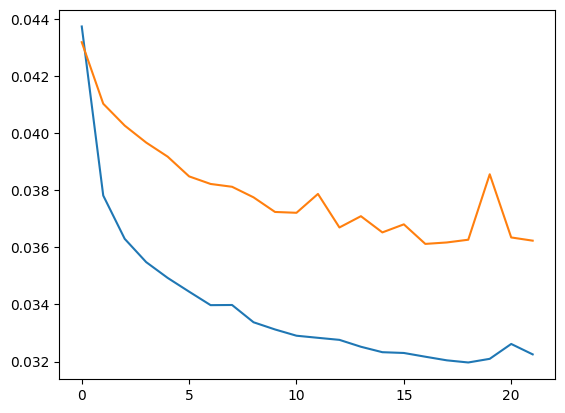

In [41]:
# plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [42]:
# Making predictions
with tf.device('GPU:1'):
    predictions = model.predict(first_lead_ecg_test.reshape(-1,1000,1))
    print(predictions.shape)

69/69 [==============================] - 1s 15ms/step
(2198, 1000, 11)


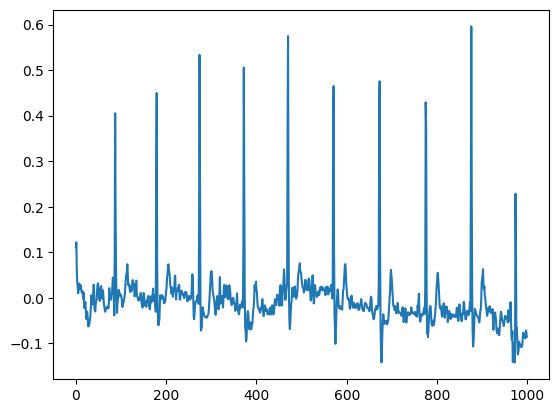

In [43]:
# plotting the first 2 predictions

plt.plot(predictions[0,:,1])
plt.show()


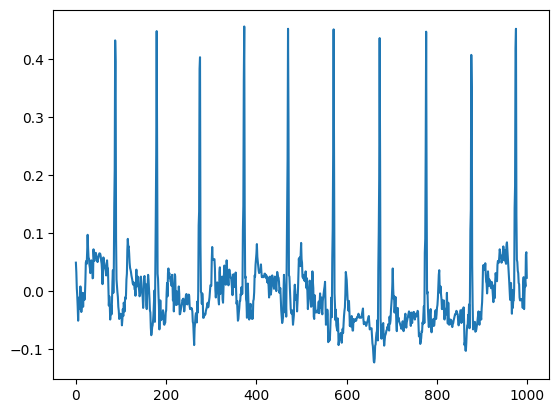

In [44]:
plt.plot(remaining_lead_ecg_test[0,:,1])
plt.show()

In [45]:
# evaluating the predictions using correlation and mean squared error

In [46]:
! pip install scikit-learn

In [47]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

In [48]:
# calculating the mean squared error
mse = mean_squared_error(remaining_lead_ecg_test.reshape(-1,1000), predictions.reshape(-1,1000))
print(mse)
# calculating rmse as the square root of mse
rmse = np.sqrt(mse)
print(rmse)

0.032817017051618325
0.18115467714530123


In [49]:
# calculating r2 score
from sklearn.metrics import r2_score
r2 = r2_score(remaining_lead_ecg_test.reshape(-1,1000), predictions.reshape(-1,1000))
print(r2)

0.42946857935084565


In [50]:
import numpy as np
from scipy.stats import pearsonr

# # Assuming you have your test data and labels
# X_test_reshaped = X_test.reshape(-1, 1000, 1)  # Reshape the test data if needed
# predictions = model.predict(X_test_reshaped)  # Get predictions for the test data

# Calculate Pearson correlation coefficient for each lead
correlations = []
for i in range(11):  # Assuming you have 11 leads
    actual = remaining_lead_ecg_test[:, :, i].flatten()  # Flatten the actual labels for the ith lead
    predicted = predictions[:, :, i].flatten()  # Flatten the predictions for the ith lead
    corr, _ = pearsonr(actual, predicted)  # Calculate Pearson correlation coefficient
    correlations.append(corr)

# Print the correlation coefficients for each lead
for i, corr in enumerate(correlations):
    print(f"Pearson correlation coefficient for lead {i+1}: {corr}")

Pearson correlation coefficient for lead 1: 0.6109388689812927
Pearson correlation coefficient for lead 2: 0.6166526390177277
Pearson correlation coefficient for lead 3: 0.8764179695234279
Pearson correlation coefficient for lead 4: 0.8781351734838461
Pearson correlation coefficient for lead 5: 0.44808925200310373
Pearson correlation coefficient for lead 6: 0.6893739177689763
Pearson correlation coefficient for lead 7: 0.675205787100872
Pearson correlation coefficient for lead 8: 0.6215191855559823
Pearson correlation coefficient for lead 9: 0.6463149418788455
Pearson correlation coefficient for lead 10: 0.669191472106763
Pearson correlation coefficient for lead 11: 0.5880225203010759


Using a different model to see if the performance improves

In [52]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('GPU:1'):
    # using a different model
    model = Sequential()
    model.add(LSTM(units=128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))  # Adding dropout regularization
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))  # Adding dropout regularization
    model.add(Dense(units=32, activation='relu'))  # Adding a dense layer
    model.add(Dense(units=11, activation='linear'))  # Output layer with 11 neurons for 11 leads
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    # Training the model
    history = model.fit(first_lead_ecg_train.reshape(-1,1000,1), remaining_lead_ecg_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=5)])
except RuntimeError as e:
  print(e)


Epoch 1/100
490/490 [==============================] - 46s 89ms/step - loss: 0.0411 - val_loss: 0.0401
Epoch 2/100
490/490 [==============================] - 42s 86ms/step - loss: 0.0362 - val_loss: 0.0392
Epoch 3/100
490/490 [==============================] - 42s 87ms/step - loss: 0.0351 - val_loss: 0.0379
Epoch 4/100
490/490 [==============================] - 43s 87ms/step - loss: 0.0343 - val_loss: 0.0377
Epoch 5/100
490/490 [==============================] - 43s 87ms/step - loss: 0.0337 - val_loss: 0.0372
Epoch 6/100
490/490 [==============================] - 43s 87ms/step - loss: 0.0334 - val_loss: 0.0371
Epoch 7/100
490/490 [==============================] - 42s 87ms/step - loss: 0.0331 - val_loss: 0.0366
Epoch 8/100
490/490 [==============================] - 43s 87ms/step - loss: 0.0330 - val_loss: 0.0364
Epoch 9/100
490/490 [==============================] - 42s 87ms/step - loss: 0.0328 - val_loss: 0.0365
Epoch 10/100
490/490 [==============================] - 43s 87ms/step - l

In [ ]:
# # using a different model
# model = Sequential()
# model.add(LSTM(units=128, input_shape=input_shape, return_sequences=True))
# model.add(Dropout(0.2))  # Adding dropout regularization
# model.add(LSTM(units=64, return_sequences=True))
# model.add(Dropout(0.2))  # Adding dropout regularization
# model.add(Dense(units=32, activation='relu'))  # Adding a dense layer
# model.add(Dense(units=11, activation='linear'))  # Output layer with 11 neurons for 11 leads

In [ ]:
# # Training the model
# history = model.fit(first_lead_ecg_train.reshape(-1,1000,1), remaining_lead_ecg_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=5)])

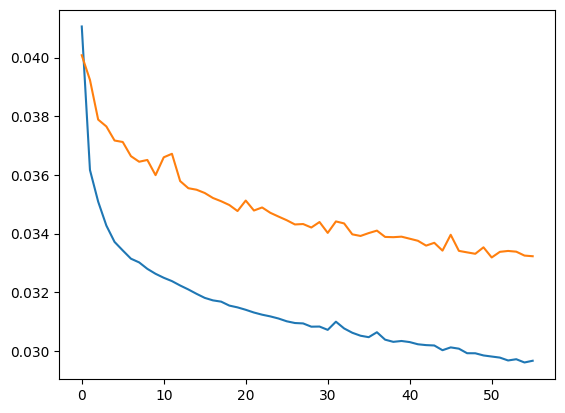

In [57]:
# plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [62]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('GPU:1'):
    # Making predictions
    predictions = model.predict(first_lead_ecg_test.reshape(-1,1000,1))
    print(predictions.shape)
except RuntimeError as e:
  print(e)


69/69 [==============================] - 3s 33ms/step
(2198, 1000, 11)


In [ ]:
# # Making predictions
# predictions = model.predict(first_lead_ecg_test.reshape(-1,1000,1))
# print(predictions.shape)

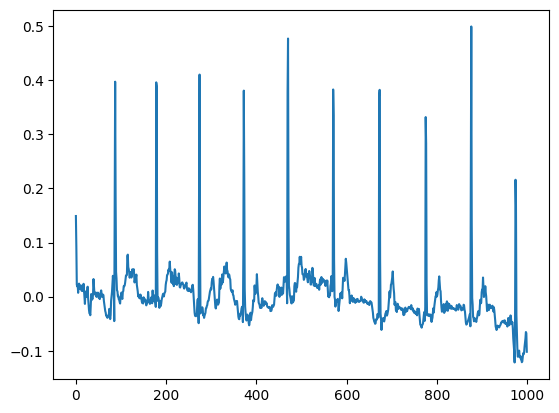

In [63]:
# plotting a prediction
plt.plot(predictions[0,:,1])
plt.show()

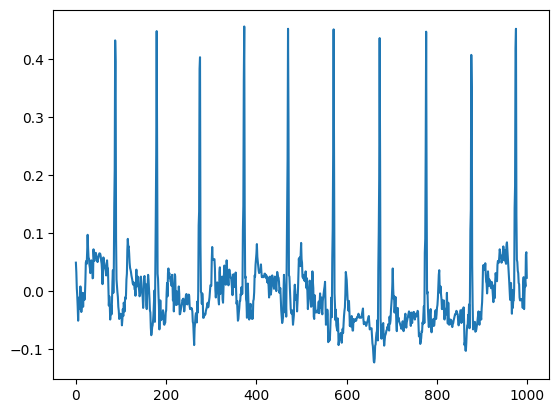

In [64]:
plt.plot(remaining_lead_ecg_test[0,:,1])
plt.show()

In [65]:
# calculating the mean squared error
mse = mean_squared_error(remaining_lead_ecg_test.reshape(-1,1000), predictions.reshape(-1,1000))
print(mse)
# calculating rmse as the square root of mse
rmse = np.sqrt(mse)
print(rmse)

0.030826270135557388
0.17557411579033336


In [66]:
# calculating r2 score
from sklearn.metrics import r2_score
r2 = r2_score(remaining_lead_ecg_test.reshape(-1,1000), predictions.reshape(-1,1000))
print(r2)

0.46432005721441805


In [68]:
import numpy as np
from scipy.stats import pearsonr

# # Assuming you have your test data and labels
# X_test_reshaped = X_test.reshape(-1, 1000, 1)  # Reshape the test data if needed
# predictions = model.predict(X_test_reshaped)  # Get predictions for the test data

# Calculate Pearson correlation coefficient for each lead
correlations = []
for i in range(11):  # Assuming you have 11 leads
    actual = remaining_lead_ecg_test[:, :, i].flatten()  # Flatten the actual labels for the ith lead
    predicted = predictions[:, :, i].flatten()  # Flatten the predictions for the ith lead
    corr, _ = pearsonr(actual, predicted)  # Calculate Pearson correlation coefficient
    correlations.append(corr)

# Print the correlation coefficients for each lead
for i, corr in enumerate(correlations):
    print(f"Pearson correlation coefficient for lead {i+1}: {corr}")

Pearson correlation coefficient for lead 1: 0.6396563114190426
Pearson correlation coefficient for lead 2: 0.6416535738302891
Pearson correlation coefficient for lead 3: 0.8822671527652951
Pearson correlation coefficient for lead 4: 0.8816246018447473
Pearson correlation coefficient for lead 5: 0.4968457625683868
Pearson correlation coefficient for lead 6: 0.7072006123156416
Pearson correlation coefficient for lead 7: 0.7040855706135566
Pearson correlation coefficient for lead 8: 0.6523349793765135
Pearson correlation coefficient for lead 9: 0.6786113604905923
Pearson correlation coefficient for lead 10: 0.690084760967948
Pearson correlation coefficient for lead 11: 0.6031350079206969
